In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from prophet import Prophet

curr = Path.cwd() 
path = curr.parent.parent
file = str(path)
file+="/data_cleanup/cleaned_data.csv"
#print(file)

In [2]:
df = pd.read_csv(file)
df.head()

,Unnamed: 0,hotel_id,datum_dolaska,datum_kreiranja_rezervacije,datum_odjave,datum_otkazivanja_rezervacije,broj_odraslih_gostiju,broj_djece_gostiju,zemlja_gosta,kanal_prodaje_id,tip_sobe_id,cijena_nocenja,status_rezervacije,rezervacija_id,gost_id,broj_nocenja,ukupno_placeno
0,0,0,2015-07-01,2015-01-21,2015-07-01,NaN,2,0.0,PRT,0,0,100.000000,Check-Out,1313223,1077152,1.0,100.000000
1,1,0,2015-07-01,2015-06-10,2015-07-01,NaN,2,0.0,PRT,0,0,100.000000,Check-Out,1313224,1017906,1.0,100.000000
2,2,0,2015-07-01,2015-05-13,2015-07-02,NaN,1,0.0,GBR,0,1,64.991345,Check-Out,1313225,1039896,1.0,64.991345
3,3,0,2015-07-01,2014-05-30,2015-07-02,NaN,1,0.0,GBR,1,1,74.368897,Check-Out,1313226,1008245,1.0,74.368897
4,4,0,2015-07-01,2014-07-06,2015-07-03,NaN,2,0.0,GBR,2,1,130.973278,Check-Out,1313227,1093703,2.0,261.946557


In [3]:
df = df[df["status_rezervacije"] == "Check-Out"]
df['datum_dolaska'] = pd.to_datetime(df['datum_dolaska'])
df['datum_kreiranja_rezervacije'] = pd.to_datetime(df['datum_kreiranja_rezervacije'])
df['datum_otkazivanja_rezervacije'] = pd.to_datetime(df['datum_otkazivanja_rezervacije'])
df.head()

,Unnamed: 0,hotel_id,datum_dolaska,datum_kreiranja_rezervacije,datum_odjave,datum_otkazivanja_rezervacije,broj_odraslih_gostiju,broj_djece_gostiju,zemlja_gosta,kanal_prodaje_id,tip_sobe_id,cijena_nocenja,status_rezervacije,rezervacija_id,gost_id,broj_nocenja,ukupno_placeno
0,0,0,2015-07-01,2015-01-21,2015-07-01,NaT,2,0.0,PRT,0,0,100.000000,Check-Out,1313223,1077152,1.0,100.000000
1,1,0,2015-07-01,2015-06-10,2015-07-01,NaT,2,0.0,PRT,0,0,100.000000,Check-Out,1313224,1017906,1.0,100.000000
2,2,0,2015-07-01,2015-05-13,2015-07-02,NaT,1,0.0,GBR,0,1,64.991345,Check-Out,1313225,1039896,1.0,64.991345
3,3,0,2015-07-01,2014-05-30,2015-07-02,NaT,1,0.0,GBR,1,1,74.368897,Check-Out,1313226,1008245,1.0,74.368897
4,4,0,2015-07-01,2014-07-06,2015-07-03,NaT,2,0.0,GBR,2,1,130.973278,Check-Out,1313227,1093703,2.0,261.946557


In [4]:
df['ukupan_broj_gostiju'] = df['broj_odraslih_gostiju'] + df['broj_djece_gostiju']
occupancy = df[(df['datum_otkazivanja_rezervacije'].isna())]
occupancy['datum_dolaska'] = pd.to_datetime(occupancy['datum_dolaska'])
occupancy['datum_odjave'] = pd.to_datetime(occupancy['datum_odjave'])
#print(occupancy)

# Za svaku rezervaciju generiranje svih datuma boravka
dates = []
for index, row in occupancy.iterrows():
    delta = (row['datum_odjave'] - row['datum_dolaska']).days
    for i in range(delta):
        dates.append((row['datum_dolaska'] + pd.Timedelta(days=i), row['ukupan_broj_gostiju']))

# Pretvaranje u DataFrame
dates_df = pd.DataFrame(dates, columns=['datum', 'broj_gostiju'])

# Grupiranje po datumu i sumiranje broja gostiju
final_df = dates_df.groupby('datum')['broj_gostiju'].sum().reset_index()
final_df.head()

,datum,broj_gostiju
0,2015-01-01,10.0
1,2015-01-02,16.0
2,2015-01-03,19.0
3,2015-01-04,24.0
4,2015-01-05,25.0


In [8]:
final_df.rename(columns={'datum': 'ds', 'broj_gostiju': 'y'}, inplace=True)

In [9]:
final_df.head()

,ds,y
0,2015-01-01,10.0
1,2015-01-02,16.0
2,2015-01-03,19.0
3,2015-01-04,24.0
4,2015-01-05,25.0


In [10]:
m = Prophet(interval_width=0.95, daily_seasonality=True)
model = m.fit(final_df)

09:38:23 - cmdstanpy - INFO - Chain [1] start processing
09:38:23 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
future = m.make_future_dataframe(periods=100,freq='D')  # 100 dana u buducnosti
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01,18.790697,-88.524953,375.292225,18.790697,18.790697,123.558391,123.558391,123.558391,35.431449,...,-0.905063,-0.905063,-0.905063,89.032005,89.032005,89.032005,0.0,0.0,0.0,142.349088
1,2015-01-02,20.022791,-100.752136,377.505930,20.022791,20.022791,128.382296,128.382296,128.382296,35.431449,...,15.669243,15.669243,15.669243,77.281604,77.281604,77.281604,0.0,0.0,0.0,148.405087
2,2015-01-03,21.254884,-98.936999,375.719572,21.254884,21.254884,135.374468,135.374468,135.374468,35.431449,...,35.094289,35.094289,35.094289,64.848729,64.848729,64.848729,0.0,0.0,0.0,156.629352
3,2015-01-04,22.486978,-147.509132,337.577039,22.486978,22.486978,71.050916,71.050916,71.050916,35.431449,...,-16.216382,-16.216382,-16.216382,51.835848,51.835848,51.835848,0.0,0.0,0.0,93.537894
4,2015-01-05,23.719072,-157.782357,298.437087,23.719072,23.719072,62.569184,62.569184,62.569184,35.431449,...,-11.211566,-11.211566,-11.211566,38.349301,38.349301,38.349301,0.0,0.0,0.0,86.288256


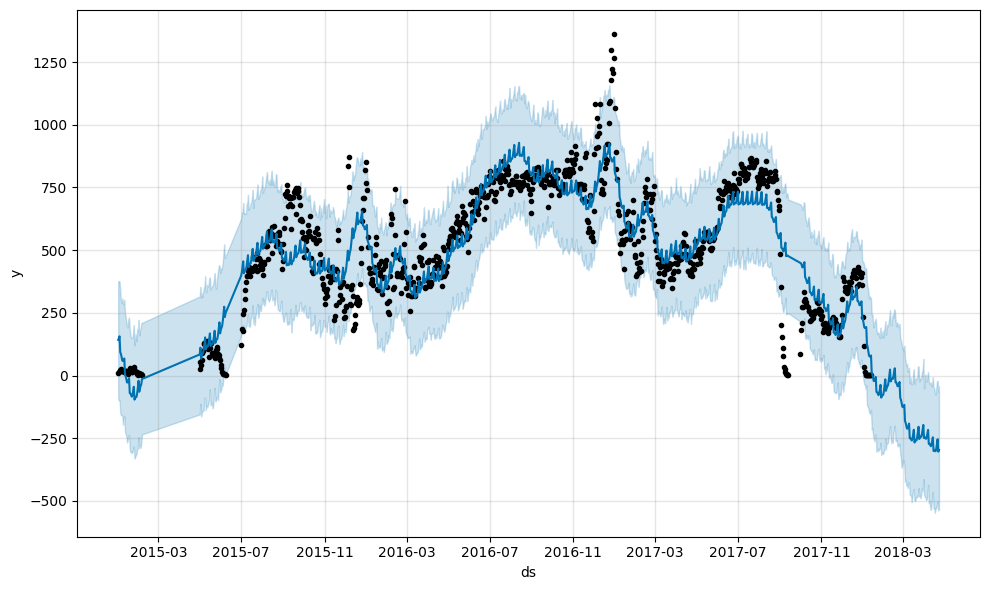

In [12]:
plot1 = m.plot(forecast)

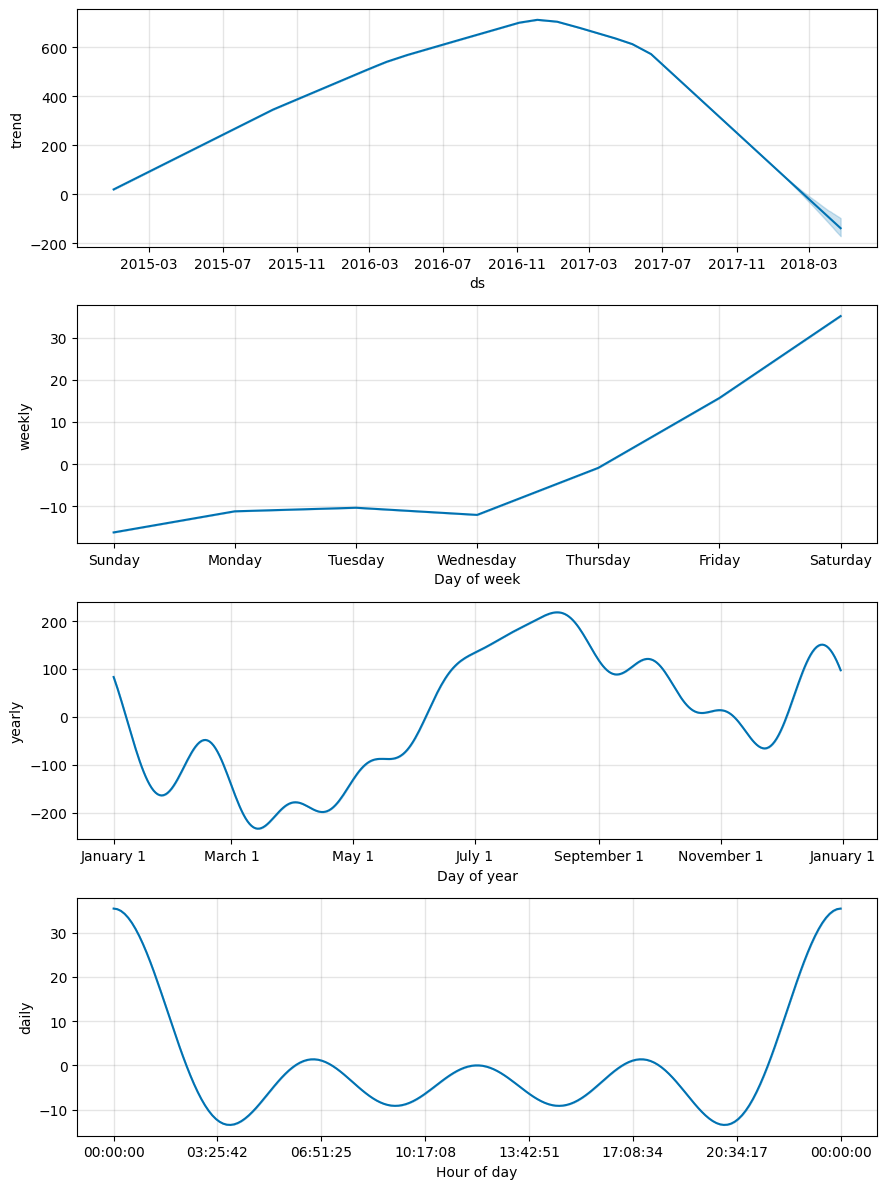

In [13]:
plt2 = m.plot_components(forecast)

In [20]:
def calculate_mape(y_true, y_pred):
    """ Calculate mean absolute percentage error (MAPE)"""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def calculate_mpe(y_true, y_pred):
    """ Calculate mean percentage error (MPE)"""
    return np.mean((y_true - y_pred) / y_true) * 100

def calculate_mae(y_true, y_pred):
    """ Calculate mean absolute error (MAE)"""
    return np.mean(np.abs(y_true - y_pred)) * 100

def calculate_rmse(y_true, y_pred):
    """ Calculate root mean square error (RMSE)"""
    return np.sqrt(np.mean((y_true - y_pred)**2))

def print_error_metrics(y_true, y_pred):
    print('MAPE: %f'%calculate_mape(y_true, y_pred))
    print('MPE: %f'%calculate_mpe(y_true, y_pred))
    print('MAE: %f'%calculate_mae(y_true, y_pred))
    print('RMSE: %f'%calculate_rmse(y_true, y_pred))
    return

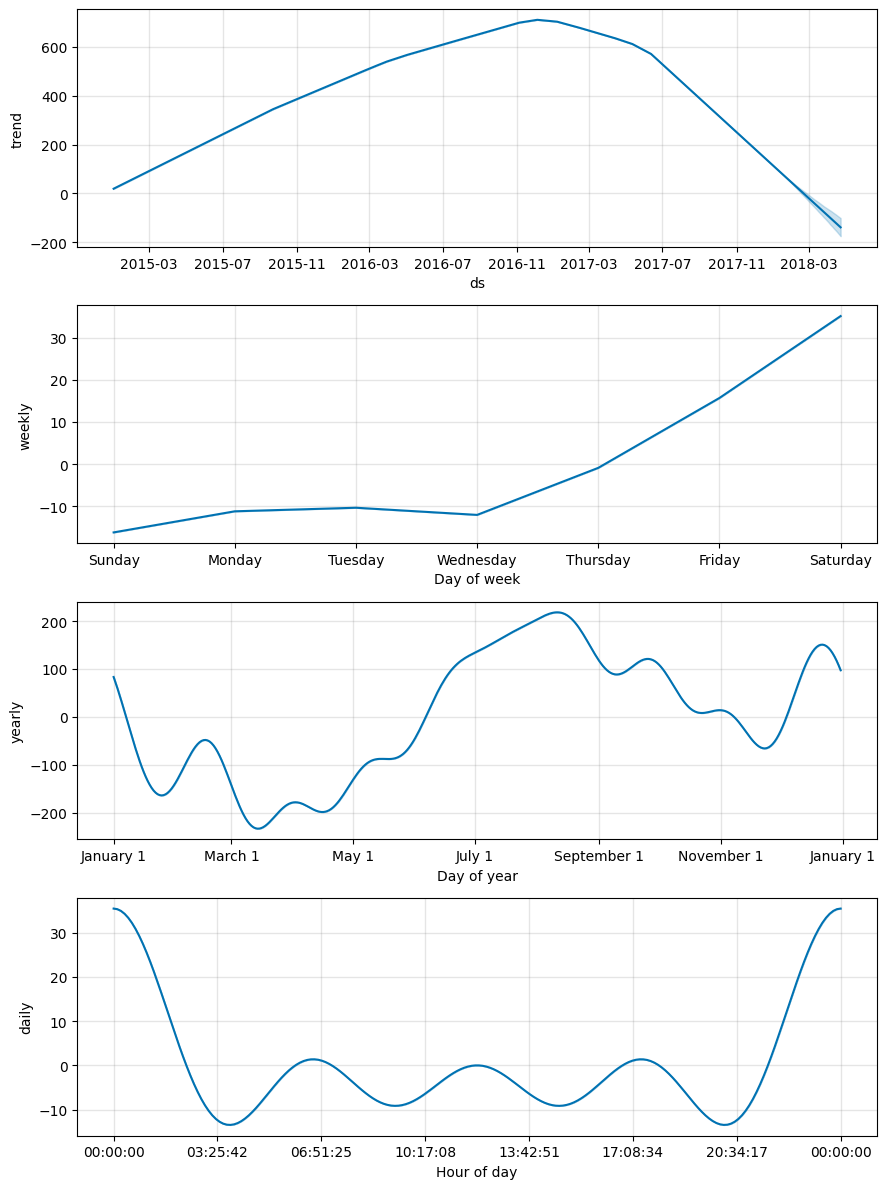

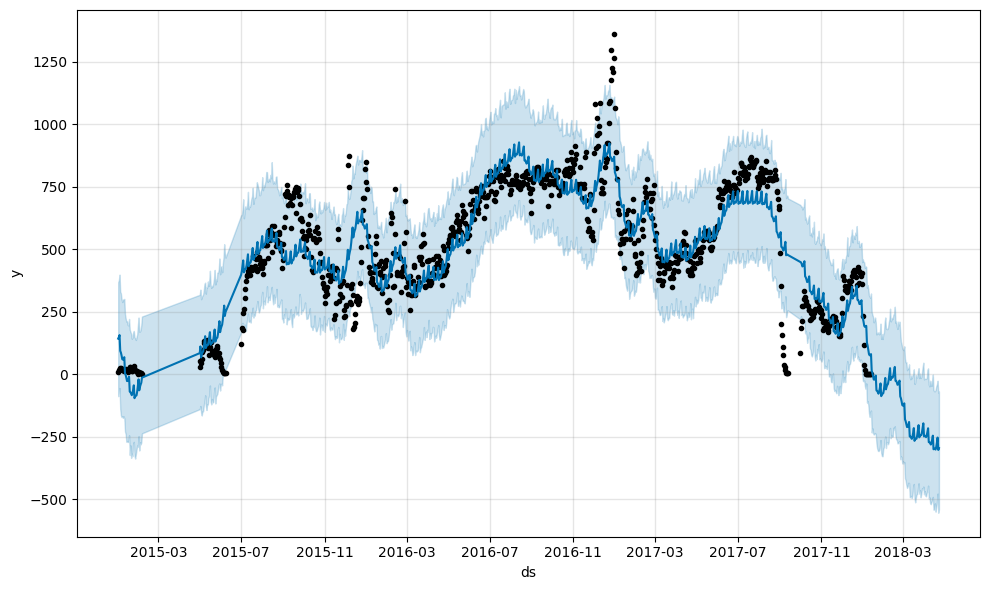

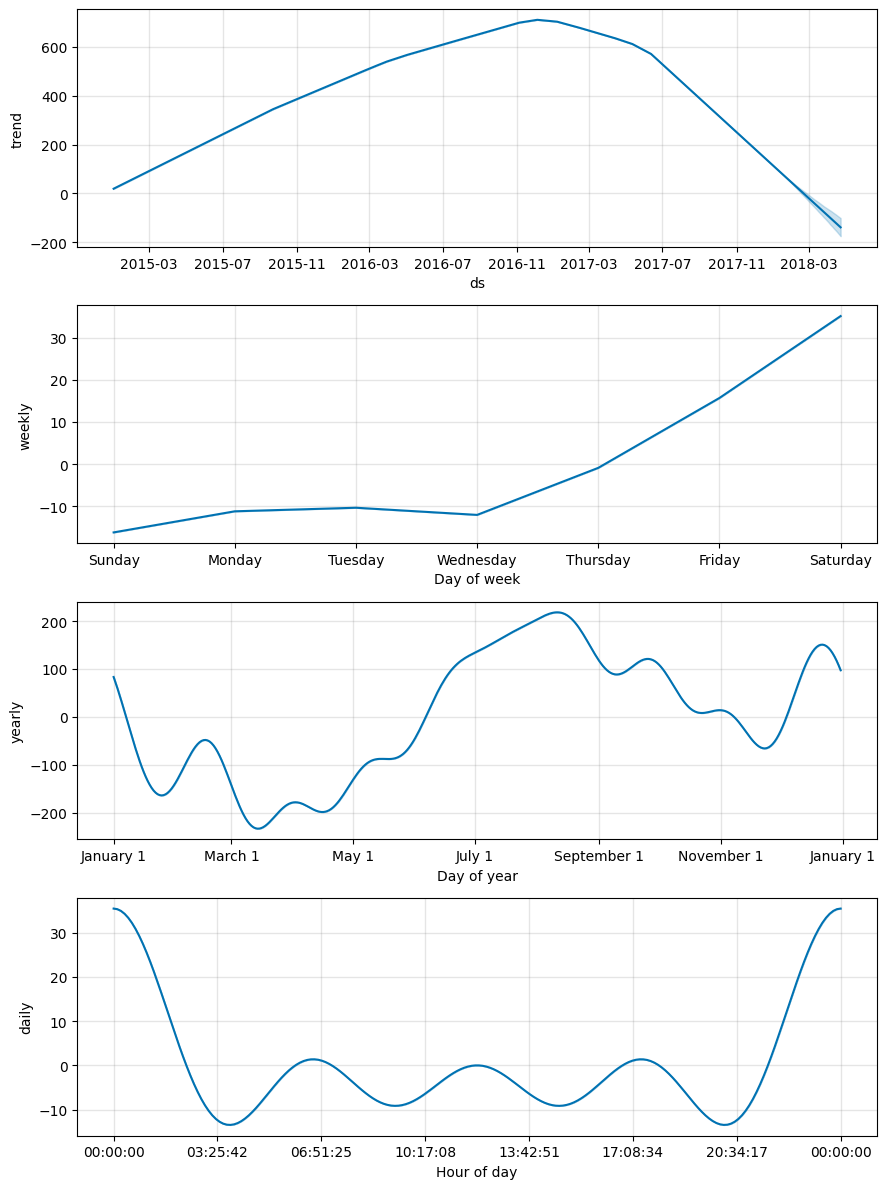

In [23]:
fcst = m.predict(future)

# Plot
m.plot(fcst);
m.plot_components(fcst)

In [24]:
print_error_metrics(y_true = final_df['y'], y_pred = fcst['yhat'])

MAPE: 1123.355047
MPE: -908.593184
MAE: 10674.049803
RMSE: 151.302623
